In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../data/processed/dataset.csv")
df.head()

,date_since,month,day,hour,dow,weekend,season,icon,usage_lag_1h,usage_lag_24h,usage
0,0,5,1,0,fri,0,summer,rain,0.0,0.0,9.0
1,0,5,1,1,fri,0,summer,rain,9.0,0.0,0.0
2,0,5,1,2,fri,0,summer,rain,0.0,0.0,4.0
3,0,5,1,3,fri,0,summer,rain,4.0,0.0,1.0
4,0,5,1,4,fri,0,summer,rain,1.0,0.0,4.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38016 entries, 0 to 38015
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date_since     38016 non-null  int64  
 1   month          38016 non-null  int64  
 2   day            38016 non-null  int64  
 3   hour           38016 non-null  int64  
 4   dow            38016 non-null  object 
 5   weekend        38016 non-null  int64  
 6   season         38016 non-null  object 
 7   icon           38016 non-null  object 
 8   usage_lag_1h   38016 non-null  float64
 9   usage_lag_24h  38016 non-null  float64
 10  usage          38016 non-null  float64
dtypes: float64(3), int64(5), object(3)
memory usage: 3.2+ MB


In [4]:
df.describe()

,date_since,month,day,hour,weekend,usage_lag_1h,usage_lag_24h,usage
count,38016.000000,38016.000000,38016.000000,38016.000000,38016.000000,38016.000000,38016.000000,38016.000000
mean,791.500000,6.521465,15.741162,11.500000,0.285985,366.368003,365.979877,366.375289
std,457.267336,3.326862,8.806316,6.922278,0.451888,348.647777,348.518849,348.643015
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,395.750000,4.000000,8.000000,5.750000,0.000000,70.000000,69.000000,70.000000
50%,791.500000,7.000000,16.000000,11.500000,0.000000,276.000000,276.000000,276.000000
75%,1187.250000,9.000000,23.000000,17.250000,1.000000,559.000000,559.000000,559.000000
max,1583.000000,12.000000,31.000000,23.000000,1.000000,2016.000000,2016.000000,2016.000000


In [5]:
y = df["usage"]
X = df.drop(columns="usage")

In [ ]:
from sklearn.model_selection import train_test_split

# --- STEP 1: SPLIT DATA INTO (TRAIN + VALID) AND (TEST) ---
# We reserve 20% of the total dataset for the final testing phase.
X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# --- STEP 2: SPLIT (TRAIN + VALID) INTO (TRAIN) AND (VALID) ---
# By taking 25% of the remaining 80%, we allocate exactly 20% of the 
# original total data to the Validation set.
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid, y_train_valid, test_size=0.25, random_state=42, shuffle=True
)

# Final verification of dataset sizes
print(f"Train size: {len(X_train)} | Valid size: {len(X_valid)} | Test size: {len(X_test)}")

Train size: 22809 | Valid size: 7603 | Test size: 7604



>>> RUNNING VALIDATION PHASE <<<


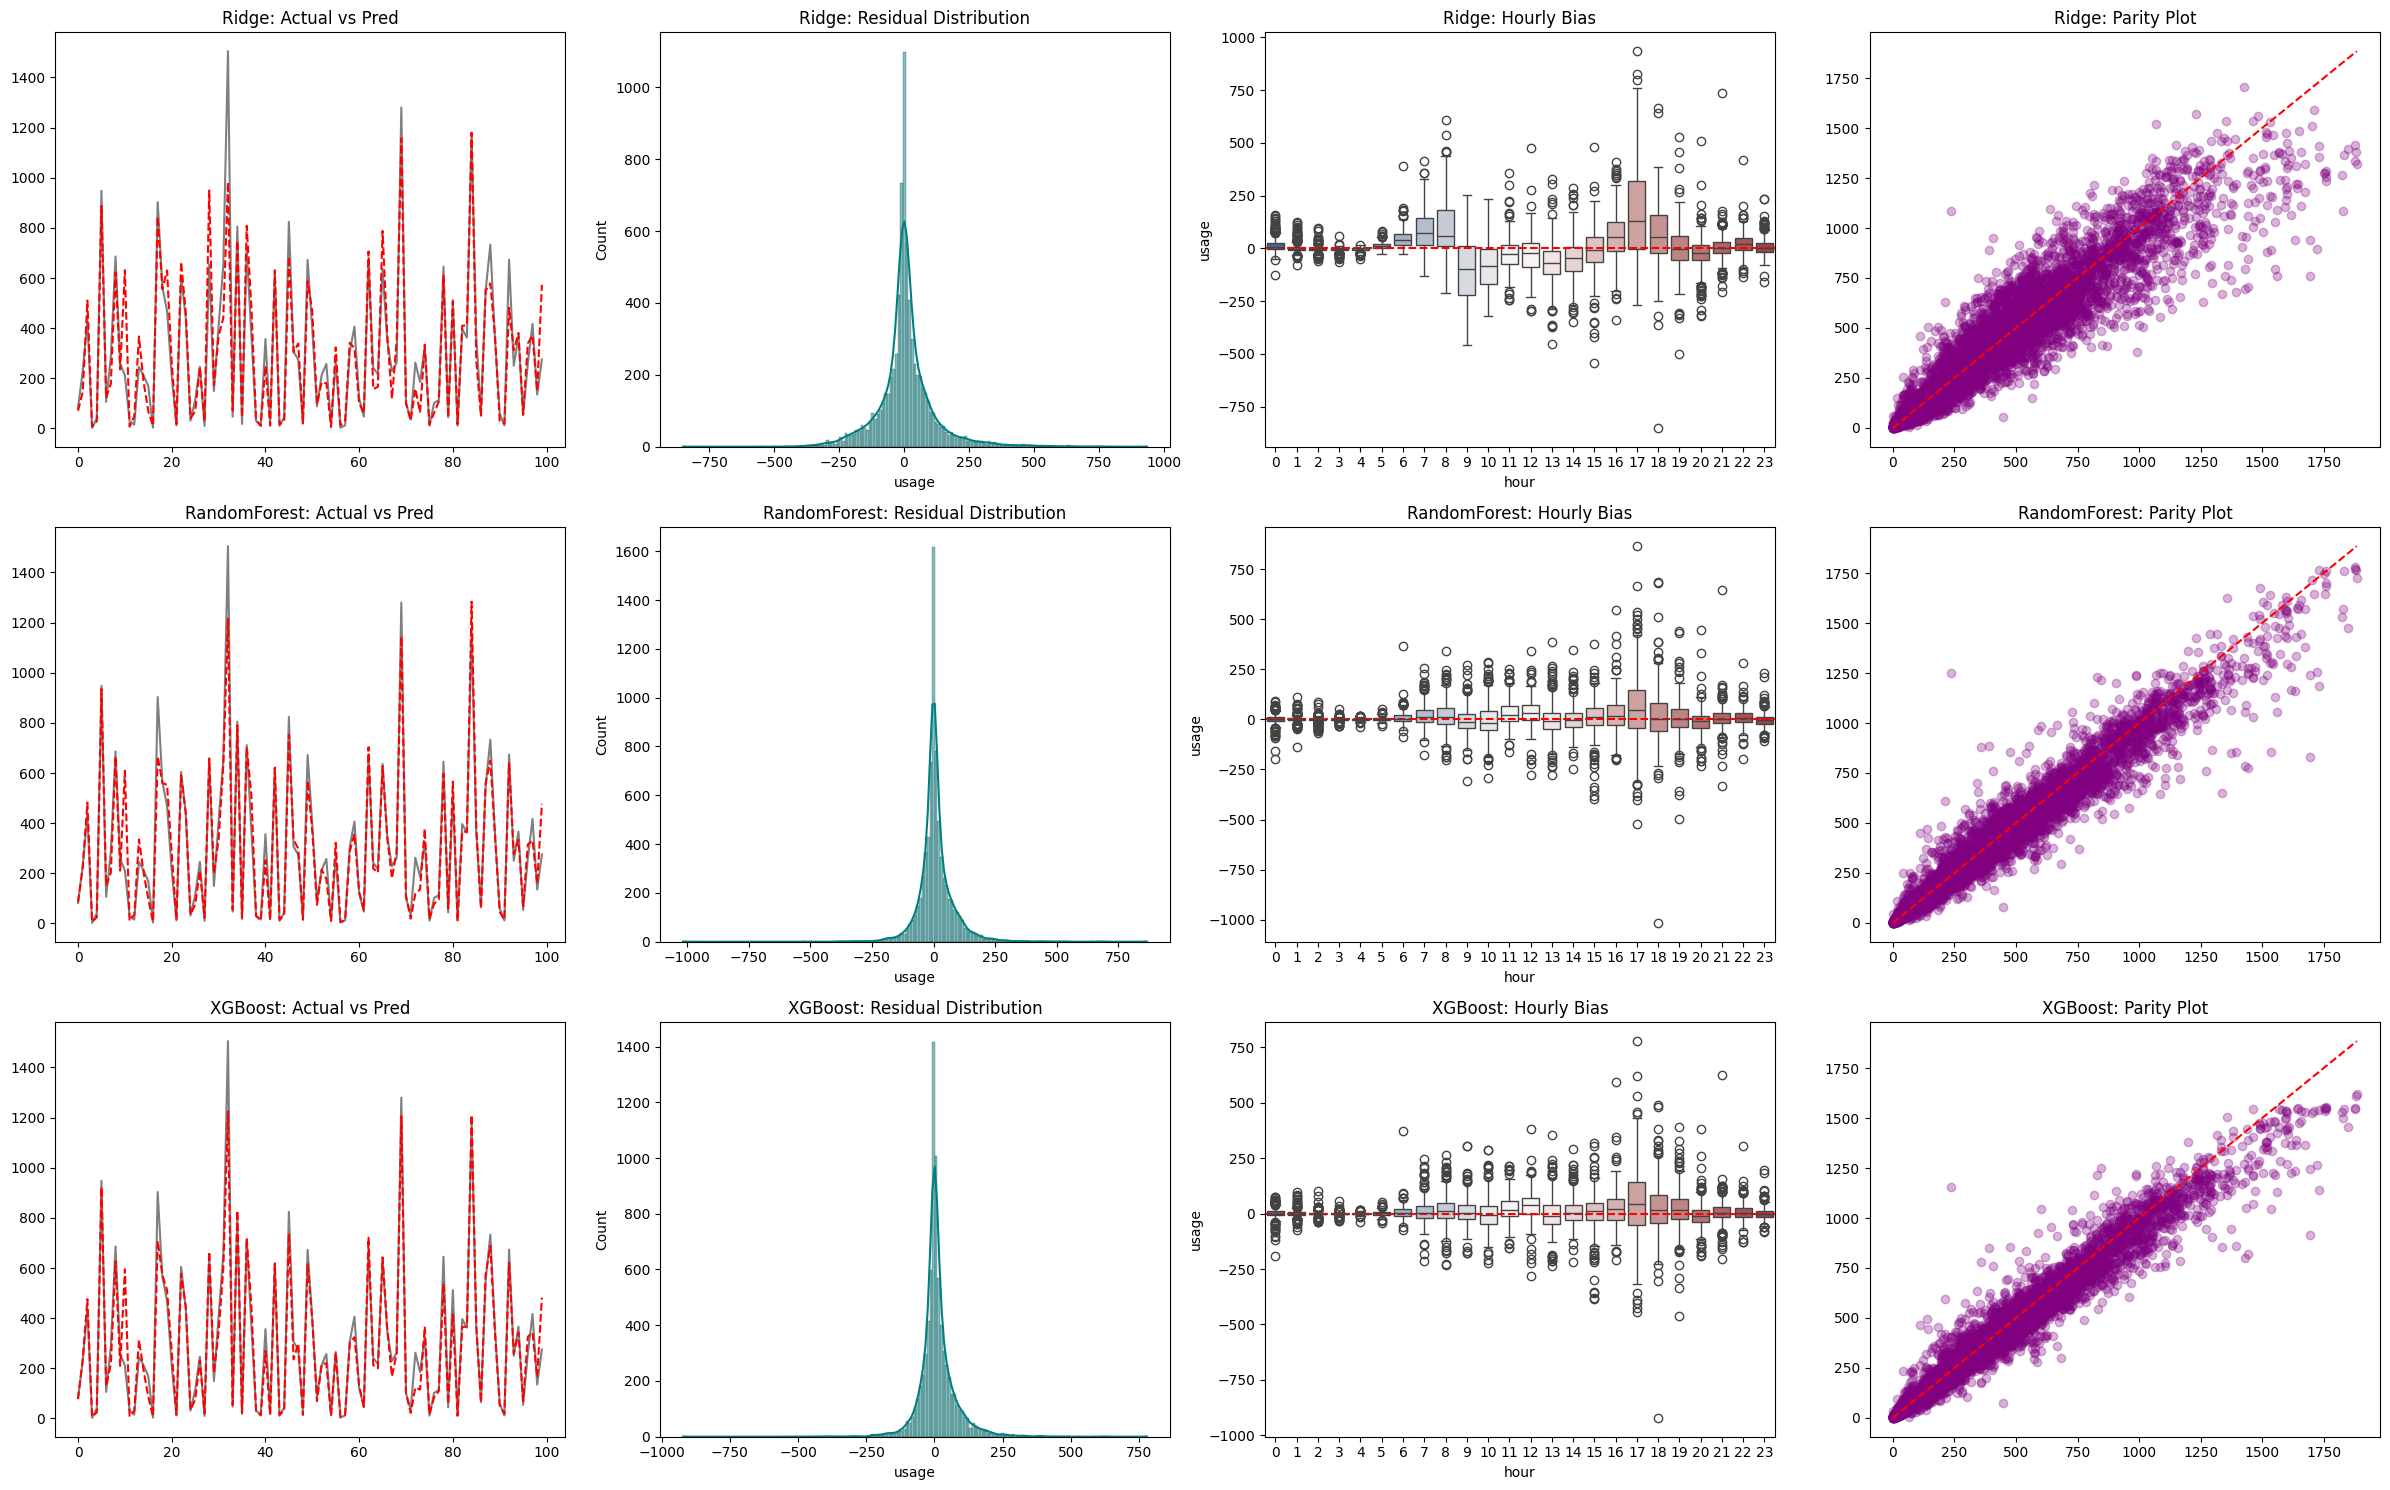

Validation Leaderboard:
          Model  WAPE (%)    MAE    RMSE      R2
2       XGBoost     11.30  41.16   69.81  0.9703
1  RandomForest     12.15  44.23   75.01  0.9673
0         Ridge     18.99  69.15  112.93  0.9391


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# --- STEP 1: DEFINE PREPROCESSING PIPELINE ---
categorical_features = ["dow", "icon", "weekend", "season"] 
numeric_features = ["date_since", "hour", "day", "month"]
lag_features = ["usage_lag_1h", "usage_lag_24h"]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        # Fix: feature_names_out avoids AttributeError
        ('log', FunctionTransformer(np.log1p, feature_names_out='one-to-one'), lag_features),
        ('num', 'passthrough', numeric_features)
    ]
)

feature_processing_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])

# --- STEP 2: REUSABLE EVALUATION & PLOTTING ENGINE ---
def evaluate_and_plot(models_dict, X_train, y_train, X_eval, y_eval, feature_pipeline, stage_name):
    """
    Fits models on training data, predicts on evaluation data, 
    calculates metrics, and generates 4 diagnostic plots per model.
    """
    results = []
    num_models = len(models_dict)
    fig, axes = plt.subplots(num_models, 4, figsize=(24, 5 * num_models))
    if num_models == 1: axes = np.expand_dims(axes, axis=0)

    print(f"\n>>> RUNNING {stage_name.upper()} PHASE <<<")
    
    for idx, (name, model) in enumerate(models_dict.items()):
        # Create full pipeline with automatic target log-transformation
        full_pipeline = Pipeline([
            ('features', feature_pipeline),
            ('model', TransformedTargetRegressor(regressor=model, func=np.log1p, inverse_func=np.expm1))
        ])
        
        # Train model
        full_pipeline.fit(X_train, y_train)
        
        # Predict on evaluation set (Validation or Test)
        y_pred = full_pipeline.predict(X_eval)
        residuals = y_eval - y_pred

        # Metrics
        rmse = np.sqrt(mean_squared_error(y_eval, y_pred))
        mae = mean_absolute_error(y_eval, y_pred)
        wape = (np.sum(np.abs(residuals)) / np.sum(y_eval)) * 100
        r2 = r2_score(np.log1p(y_eval), np.log1p(y_pred))
        
        results.append({
            "Model": name, "WAPE (%)": round(wape, 2), 
            "MAE": round(mae, 2), "RMSE": round(rmse, 2), "R2": round(r2, 4)
        })

        # Visualization
        axes[idx, 0].plot(y_eval.values[:100], label='Actual', color='black', alpha=0.5)
        axes[idx, 0].plot(y_pred[:100], label='Predicted', color='red', linestyle='--')
        axes[idx, 0].set_title(f'{name}: Actual vs Pred')
        
        sns.histplot(residuals, kde=True, ax=axes[idx, 1], color='teal')
        axes[idx, 1].set_title(f'{name}: Residual Distribution')

        sns.boxplot(x=X_eval['hour'], y=residuals, ax=axes[idx, 2], hue=X_eval['hour'], palette="vlag", legend=False)
        axes[idx, 2].axhline(0, color='red', linestyle='--')
        axes[idx, 2].set_title(f'{name}: Hourly Bias')

        axes[idx, 3].scatter(y_eval, y_pred, alpha=0.3, color='purple')
        axes[idx, 3].plot([y_eval.min(), y_eval.max()], [y_eval.min(), y_eval.max()], 'r--')
        axes[idx, 3].set_title(f'{name}: Parity Plot')

    plt.tight_layout()
    plt.show()
    return pd.DataFrame(results).sort_values(by="WAPE (%)"), full_pipeline # returns df and last trained pipeline

# --- STEP 3: PHASE 1 - VALIDATION & TUNING ---
# Define models for initial selection
candidate_models = {
    "Ridge": Ridge(alpha=10.0), # Increased alpha to avoid overflow
    "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.05, n_jobs=-1, random_state=42)
}

# Run on Validation Set
# You repeat this step as many times as needed to tune your parameters
df_valid_results, _ = evaluate_and_plot(
    candidate_models, X_train, y_train, X_valid, y_valid, 
    feature_processing_pipeline, stage_name="Validation"
)
print("Validation Leaderboard:")
print(df_valid_results)


>>> RUNNING FINAL TEST PHASE <<<


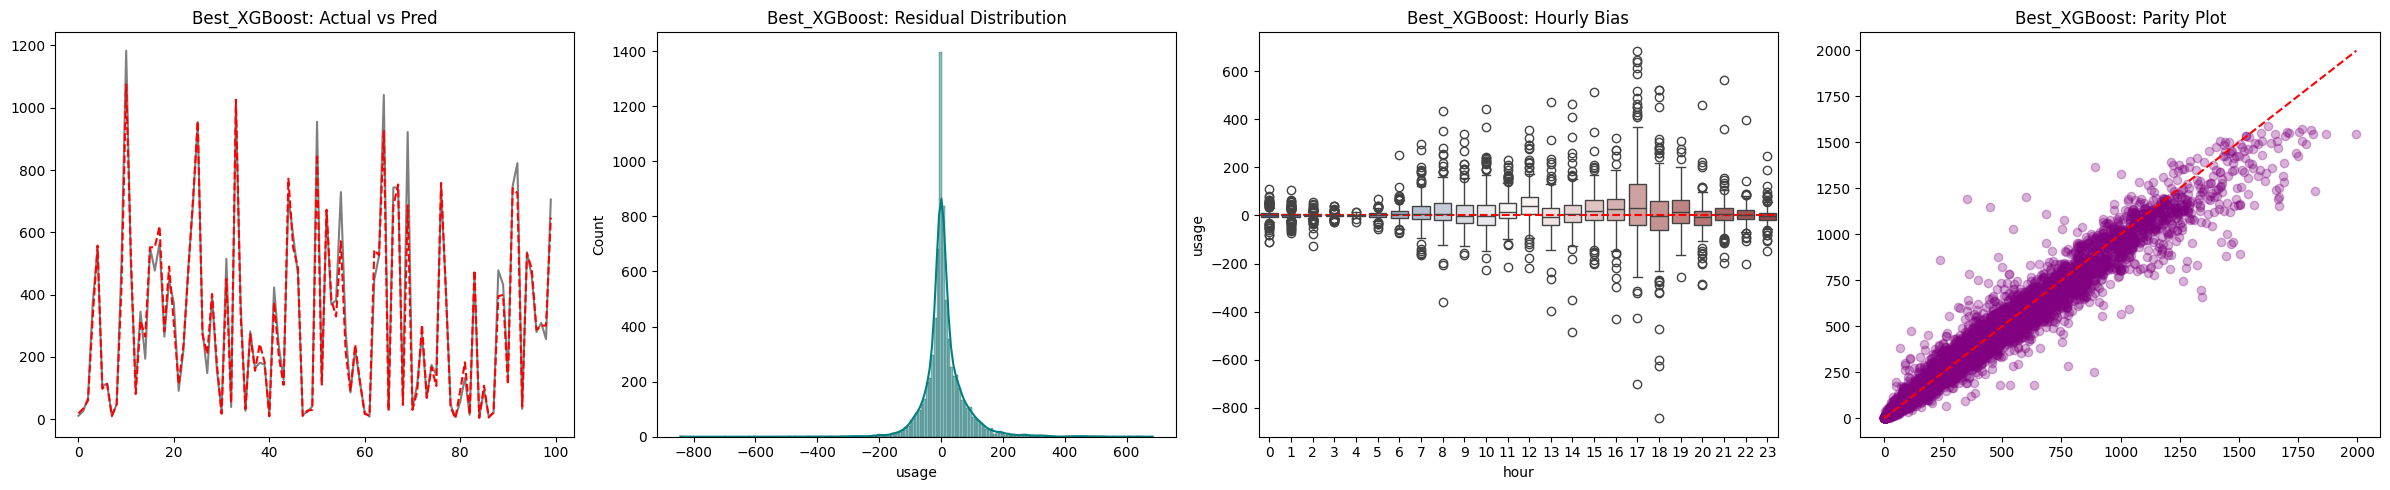


Final Test Leaderboard:
          Model  WAPE (%)    MAE   RMSE      R2
0  Best_XGBoost     11.39  42.05  73.22  0.9719


In [11]:
# --- STEP 4: PHASE 2 - FINAL TEST ---
# Once you are satisfied with your tuning, run this final block ONCE.
# Optionally, you can retrain the best model on (Train + Valid) for the final test.
final_models = {
    "Best_XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.05, n_jobs=-1, random_state=42)
}

df_test_results, best_pipeline = evaluate_and_plot(
    final_models, X_train, y_train, X_test, y_test, 
    feature_processing_pipeline, stage_name="Final Test"
)
print("\nFinal Test Leaderboard:")
print(df_test_results)